# K-mean clustering

## Imports:

In [4]:
# import pytz
# import matplotlib.ticker as mpticker
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import finnhub
import matplotlib.dates as mpl_dates
import numpy as np
from datetime import * 

## Access stock data

In [10]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'AAPL'
start_time = int(datetime(2021, 5, 18, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 18, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

## Define functions

In [15]:
def get_optimum_clusters(df, saturation_point = 0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []
    labels = []

    size = min(10, df.shape[0])
    for i in range(1, size):
        # kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans = KMeans(n_clusters = i, init='random', max_iter=300, n_init=10)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their Closest cluster center
        k_models.append(kmeans)
        labels.append(kmeans.labels_)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    labels = labels[optimum_k]

    return (optimum_clusters.cluster_centers_, labels)

## Find R&S and Plot

In [16]:
Lows = pd.DataFrame(data = stock, index = stock.index, columns = ['Low'])
Highs = pd.DataFrame(data = stock, index = stock.index, columns = ['High'])
Low_centers, low_labels = get_optimum_clusters(Lows)
High_centers, high_labels = get_optimum_clusters(Highs)
Low_centers = Low_centers.flatten()
High_centers = High_centers.flatten()
Lows['labels'] = pd.Series(low_labels, index = Lows.index)
Highs['labels'] = pd.Series(high_labels, index = Highs.index)
res = [max(Highs.loc[Highs.labels == i, 'High']) for i in np.unique(high_labels)]
sup = [min(Lows.loc[Lows.labels == i, 'Low']) for i in np.unique(low_labels)]

C:\Users\jizha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jizha\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


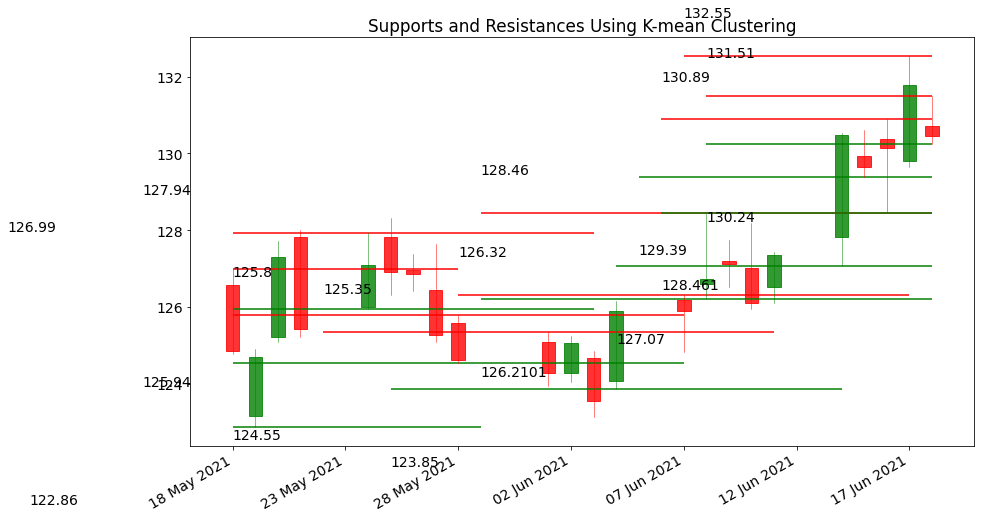

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = max(min_date_high, mu - 10), xmax = min(mu + 10, max_date_high), color = 'red')
    plt.text(x = mu - 10, y = res[i] + 1, s = str(res[i]))
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(res)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 10), xmax = min(mu + 10, max_date_low), color = 'green')
    plt.text(x = mu - 10, y = sup[i] - 2, s = str(sup[i]))

plt.title('Supports and Resistances Using K-mean Clustering')
plt.show()

## Test

In [ ]:
# Lows = pd.DataFrame(data = stock, index = stock.index, columns = ['Low'])
# Highs = pd.DataFrame(data = stock, index = stock.index, columns = ['High'])
# Low_centers, low_labels = get_optimum_clusters(Lows)
# High_centers, high_labels = get_optimum_clusters(Highs)
# Low_centers = Low_centers.flatten()
# High_centers = High_centers.flatten()
# Lows['labels'] = pd.Series(low_labels, index = Lows.index)
# Highs['labels'] = pd.Series(high_labels, index = Highs.index)
# # res = [max(Highs.loc[Highs.labels == i, 'High']) for i in np.unique(high_labels)]
# # sup = [min(Lows.loc[Lows.labels == i, 'Low']) for i in np.unique(low_labels)]

In [18]:
# plt.rcParams['figure.figsize'] = [12, 7]
# plt.rc('font', size=14)
# fig, ax = plt.subplots()

# # stock['Date'] = pd.to_datetime(stock.index)
# # stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
# # stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

# # candlestick_ohlc(ax, stock.values, width=0.6,\
# #                  colorup='green', colordown='red', alpha=0.8)

# stock['Close'].plot(ax = ax)

# date_format = mpl_dates.DateFormatter('%d %b %Y')
# ax.xaxis.set_major_formatter(date_format)
# fig.autofmt_xdate()
# fig.tight_layout()

# # Highs['Date'] = pd.to_datetime(Highs.index)
# # Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
# # min_date_high = min(Highs.Date)
# # max_date_high = max(Highs.Date)
# # for i in range(len(res)):
# #     mu = Highs[Highs.High == res[i]].Date.values[0]
# #     plt.hlines(res[i], xmin = max(min_date_high, mu - 10), xmax = min(mu + 10, max_date_high), color = 'red')
# #     plt.text(x = mu - 10, y = res[i] + 1, s = str(res[i]))
    
# # Lows['Date'] = pd.to_datetime(Lows.index)
# # Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
# # min_date_low = min(Lows.Date)
# # max_date_low = max(Lows.Date)
# # for i in range(len(res)):
# #     mu = Lows[Lows.Low == sup[i]].Date.values[0]
# #     plt.hlines(sup[i], xmin = max(min_date_low, mu - 10), xmax = min(mu + 10, max_date_low), color = 'green')
# #     plt.text(x = mu - 10, y = sup[i] - 2, s = str(sup[i]))

# plt.hlines(Low_centers, xmin = stock.index[0], xmax = stock.index[-1], color = 'green')

# plt.title('Supports and Resistances Using K-mean Clustering')
# plt.show()